In [28]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import argparse, pickle, os
from pl_modules import PLVaDE
import numpy as np 
from autoencoder import cluster_acc, SimpleAutoencoder
import pytorch_lightning as pl
import torch
import sys
from collections import defaultdict
import wandb
from pathlib import Path


def test_gmm(run_id, ds_type='train', n_runs=5):
    wandb.init(project='AE clustering', resume='must', id=run_id)
    wandb.config.update({'dataset': 'mnist', 'data_size': None, 'data_random_state': 42})
    autoencoder = SimpleAutoencoder(n_neurons=wandb.config.n_neurons, dataset=wandb.config.dataset, 
                                    data_size=wandb.config.data_size, data_random_state=wandb.config.data_random_state)
    autoencoder.prepare_data()
    run_path = Path(f'AE clustering/{run_id}')
    if not os.path.exists(run_path): 
        for path in Path('wandb').glob(f"run-*-{run_id}"):
            if os.path.exists(path / 'files' / 'AE clustering'):
                run_path = path / 'files' / 'AE clustering' / run_id 
                break

    checkpoint_files = os.listdir(run_path /'checkpoints')
    checkpoint_file = checkpoint_files[-1]
    autoencoder.load_state_dict(torch.load(run_path /'checkpoints' / checkpoint_file)['state_dict'])

    y_true = np.stack([autoencoder.all_ds[i][1] for i in range(len(autoencoder.all_ds))])
    X_encoded = autoencoder.encode_ds(autoencoder.all_ds)
    results = defaultdict(list)
    for i in range(n_runs):
        init_gmm = GaussianMixture(10, covariance_type='full', n_init=3)
        y_pred = init_gmm.fit_predict(X_encoded)
        results['log_likelihood'].append(init_gmm.score(X_encoded))
        results['acc'].append(cluster_acc(y_true, y_pred))
        results['nmi'].append(metrics.normalized_mutual_info_score(y_true, y_pred))
        results['ari'].append(metrics.adjusted_rand_score(y_true, y_pred))
        # print('log likelihood:', init_gmm.score(X_encoded))
        # print('Accuracy: ', acc)
        # print('NMI: ', nmi)
        # print('ARI: ', ari)
    return results

results2 = test_gmm('tlnld2z9', n_runs=20)


_step,16449
_runtime,1083
_timestamp,1613504076
loss,0.0108
epoch,69
bce_loss,0.09504
ACC,0.78469
ARI,0.72509
NMI,0.80923
ACC2,0.83053


wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


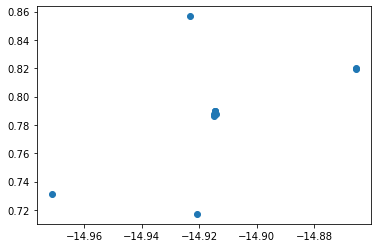

In [29]:
plt.scatter(results2['log_likelihood'], results2['acc'])

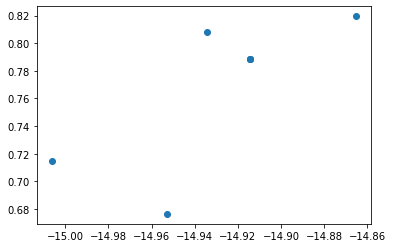

In [27]:
plt.scatter(results2['log_likelihood'], results2['acc'])

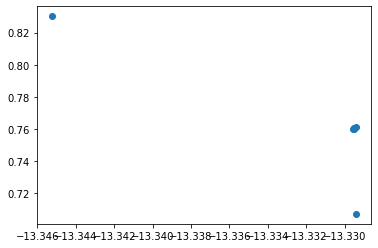

In [25]:
from matplotlib import pyplot as plt
plt.scatter(results2['log_likelihood'], results2['acc'])